In [ ]:
import os, random, shutil

def randomize_datasets(pvTrain, pvTest, pvValid, path, typeML):
    
    try:
        os.mkdir(path+'valid')
    except OSError:
        pass
    
    try:
        os.mkdir(path+'train')
    except OSError:
        pass
    
    try:
        os.mkdir(path+'test')
    except OSError:
        pass
    
    totalFiles = len(next(os.walk(path+typeML))[2])
    trainMove = 0
    testMove = 0
    validMove = 0
    
    
    # n%20 < 16 put in folder train
    # elif x%20 < 19 put in folder test
    # else (x%20 == 19) put in folder verify
    
    print ("Moving {0} files...".format(totalFiles))
    x = 0
    while (x!=totalFiles):
        random.seed();
        for root, dirs, files in os.walk(path+typeML):
            for name in files:
                chance = random.uniform(0,99)
                rfile=os.path.join(root, name)    

                if (chance % 100 < pvValid):
                    try:
                        os.mkdir(path+'valid/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'valid/'+typeML+'/')
                    validMove = validMove + 1
                    
                elif (chance % 100 < pvValid + pvTest):
                    try:
                        os.mkdir(path+'test/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'test/'+typeML+'/')
                    testMove = testMove + 1
                    
                else:
                    try:
                        os.mkdir(path+'train/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'train/'+typeML+'/')
                    trainMove = trainMove + 1
                x = x + 1
        
    print ("Moved {0} to train!".format(trainMove))
    print ("Moved {0} to test!".format(testMove))
    print ("Moved {0} to valid!".format(validMove))
 
    
randomize_datasets(80, 15, 5, 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\', 'clench_images')
randomize_datasets(80, 15, 5, 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\', 'spidey_images')


In [10]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    part_files = np.array(data['filenames'])
    part_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return part_files, part_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(bigPath + 'train')
test_files, test_targets = load_dataset(bigPath +'test')
valid_files, valid_targets = load_dataset(bigPath +'valid')

print('There are %d training part images.' % len(train_files))
print('There are %d validation part images.' % len(valid_files))
print('There are %d test part images.'% len(test_files))

There are 80 training part images.
There are 11 validation part images.
There are 14 test part images.


In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 119.98it/s]


In [12]:
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications import ResNet50

from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import applications

numGPU = 2
image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten(input_shape=(image_size, image_size, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

<keras.engine.input_layer.InputLayer object at 0x000001AE1FDA3BA8> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1FDA3C50> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1C674F98> False
<keras.layers.pooling.MaxPooling2D object at 0x000001AE1FDA3E80> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1C55A128> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1FDA2A58> False
<keras.layers.pooling.MaxPooling2D object at 0x000001AE1E67CD68> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E691F98> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E6B9780> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E6CF710> False
<keras.layers.pooling.MaxPooling2D object at 0x000001AE1E6E2E10> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E6F9FD0> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E722828> False
<keras.layers.convolutional.Conv2D object at 0x000001AE1E7357B8> False
<ker

In [13]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 100
batch_size=20

bestModelSavedName = "vgg16_frozen.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets), 
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Train on 80 samples, validate on 11 samples
Epoch 1/100
 - 10s - loss: 1.7637 - acc: 0.7625 - val_loss: 4.3719 - val_acc: 0.7273

Epoch 00001: val_loss improved from inf to 4.37188, saving model to vgg16_frozen.hdf5
Epoch 2/100
 - 3s - loss: 2.1830 - acc: 0.8625 - val_loss: 4.3719 - val_acc: 0.7273

Epoch 00002: val_loss did not improve from 4.37188
Epoch 3/100
 - 3s - loss: 1.9828 - acc: 0.8438 - val_loss: 3.9298 - val_acc: 0.7273

Epoch 00003: val_loss improved from 4.37188 to 3.92984, saving model to vgg16_frozen.hdf5
Epoch 4/100
 - 3s - loss: 1.5200 - acc: 0.8750 - val_loss: 2.7820 - val_acc: 0.8182

Epoch 00004: val_loss improved from 3.92984 to 2.78197, saving model to vgg16_frozen.hdf5
Epoch 5/100
 - 3s - loss: 1.3125 - acc: 0.8750 - val_loss: 2.8209 - val_acc: 0.7273

Epoch 00005: val_loss did not improve from 2.78197
Epoch 6/100
 - 3s - loss: 1.1234 - acc: 0.9187 - val_loss: 2.7789 - val_acc: 0.8182

Epoch 00006: val_loss improved from 2.78197 to 2.77888, saving model to vgg16


Epoch 00057: val_loss did not improve from 0.38370
Epoch 58/100
 - 4s - loss: 0.0420 - acc: 0.9813 - val_loss: 0.5593 - val_acc: 0.9091

Epoch 00058: val_loss did not improve from 0.38370
Epoch 59/100
 - 4s - loss: 0.0471 - acc: 0.9875 - val_loss: 0.8009 - val_acc: 0.9091

Epoch 00059: val_loss did not improve from 0.38370
Epoch 60/100
 - 4s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.8064 - val_acc: 0.9091

Epoch 00060: val_loss did not improve from 0.38370
Epoch 61/100
 - 4s - loss: 0.0166 - acc: 0.9875 - val_loss: 0.8043 - val_acc: 0.9091

Epoch 00061: val_loss did not improve from 0.38370
Epoch 62/100
 - 4s - loss: 0.0123 - acc: 0.9875 - val_loss: 0.8451 - val_acc: 0.9091

Epoch 00062: val_loss did not improve from 0.38370
Epoch 63/100
 - 4s - loss: 0.0380 - acc: 0.9875 - val_loss: 0.8997 - val_acc: 0.9091

Epoch 00063: val_loss did not improve from 0.38370
Epoch 64/100
 - 4s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.9228 - val_acc: 0.9091

Epoch 00064: val_loss did not improve fr

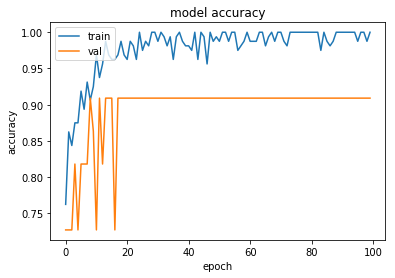

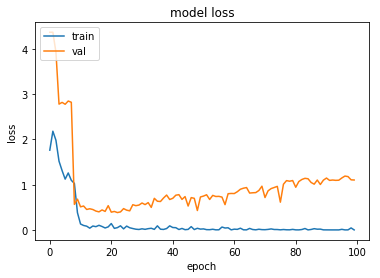

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import f1_score
import pandas as pd

model.load_weights("vgg16_frozen.hdf5")

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Test accuracy: 92.8571%
Fscore: [0.85714286 0.95238095]
Predicted  0   1  All
Actual               
0          3   0    3
1          1  10   11
All        4  10   14
